In [1]:
import os
import random
from pathlib import Path

import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
IMAGES_PATH = Path('../docs/imgs/')
DATA_PATH = Path('../data/project/')

IMAGES_PATH.mkdir(parents=True, exist_ok=True)
DATA_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
SEED = 42
BATCH_SIZE = 64

In [4]:
def seed_all(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

seed_all(SEED)

# Загрузка данных

In [5]:
from uu import encode
import pandas as pd

def load_data(file_path: Path) -> pd.DataFrame:
    data = pd.read_excel(file_path)    
    return data

In [6]:
dataframe = load_data(os.path.join(DATA_PATH, "data_1.xlsx"))
print("Number of rows and columns in the train data set:", dataframe.shape)

Number of rows and columns in the train data set: (11475, 8)


d:\Projects\NLP_course\.venv\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [7]:
dataframe.head(5)

,responsible_person,type_problem,topic,categoria,region,source,target,context
0,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! На трубопроводе центрального ото...,"[id181153628|Ольга], совершенно верно! Каждый..."
1,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Специалисты ТСК ""Мосэнерго"" пров...","[id181153628|Ольга], совершенно верно! Каждый..."
2,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Конкретизируйте, пожалуйста, Ваш...","[id181153628|Ольга], совершенно верно! Каждый..."
3,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! Спасибо за Ваш вопрос. В микрора...,"[id181153628|Ольга], совершенно верно! Каждый..."
4,Администрация Химки,Устранение проблемы,"Неудовлетворительное качество товара, оказания...","Торговля, товары и услуги",Орехово-Зуевский,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Укажите, пожалуйста, точный адре...","[id181153628|Ольга], совершенно верно! Каждый..."


In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11475 entries, 0 to 11474
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   responsible_person  11475 non-null  object
 1   type_problem        11475 non-null  object
 2   topic               11475 non-null  object
 3   categoria           11475 non-null  object
 4   region              11475 non-null  object
 5   source              11150 non-null  object
 6   target              11465 non-null  object
 7   context             11475 non-null  object
dtypes: object(8)
memory usage: 717.3+ KB


In [9]:
dataframe.describe()

,responsible_person,type_problem,topic,categoria,region,source,target,context
count,11475,11475,11475,11475,11475,11150,11465,11475
unique,181,11,120,11,56,5534,9821,5694
top,Александр Αлексеев,Устранение проблемы,-,ЖКХ,Другие регионы,Это ситуация в доме 15/2 - результат полного о...,Здравствуйте! Спасибо за Ваш вопрос. В микрора...,"[id4847589|Александр], кто ответит за нанесён..."
freq,717,8365,1663,4848,2513,24,111,24


## Анализ данных

In [10]:
def plot_hist(dataframe: pd.DataFrame, column: str):
    category_counts = dataframe.groupby(column).size().sort_values(ascending=False)

    # Calculating percentages
    total_messages = category_counts.sum()
    percentages = (category_counts / total_messages * 100).round(2)

    # Plotting a bar chart for the message counts by category
    plt.figure(figsize=(12, 8))
    bars = plt.bar(category_counts.index, category_counts.values, color='skyblue')

    plt.title('Распределение сообщений по '+column, fontsize=15, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Количество сообщений', fontsize=12)
    plt.xticks(rotation=45, ha="right")

    
    # Adding absolute values and percentages on top of each bar
    for bar, percentage in zip(bars, percentages):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}\n({percentage}%)', ha='center', va='bottom', fontsize=7)
        

    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    save_fig(column+'_hist')
    plt.show()

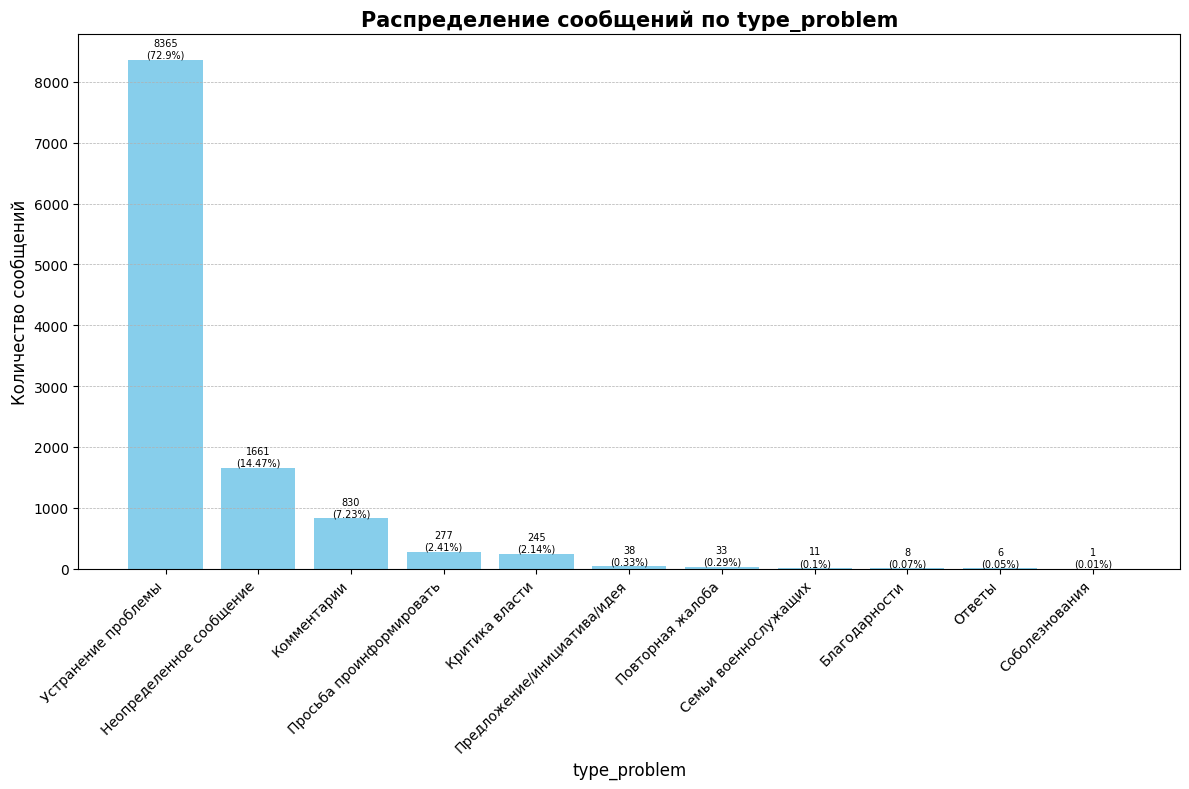

In [11]:
plot_hist(dataframe, 'type_problem')

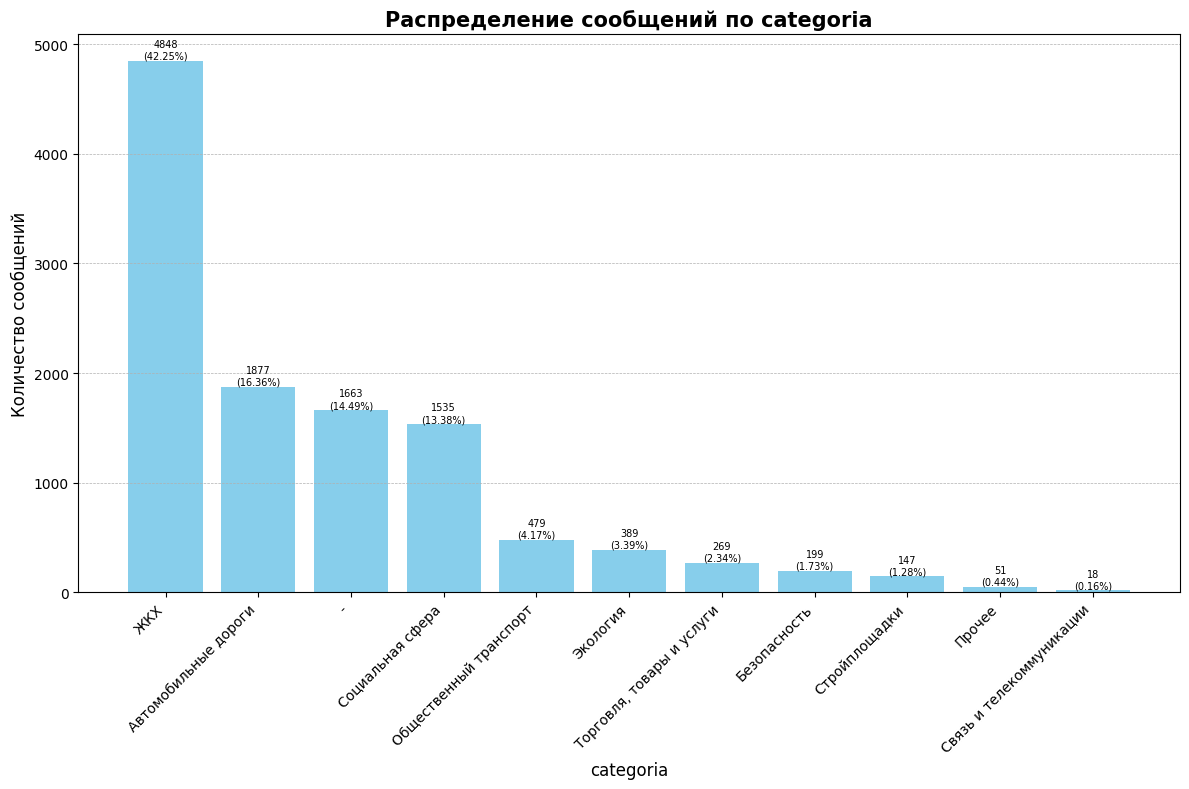

In [12]:
plot_hist(dataframe, 'categoria')

In [35]:
from graphviz import Digraph

# Создаем объект Digraph для генерации диаграммы
dot = Digraph(comment='Custom GPT-2 Model Architecture')

# Добавляем узлы, соответствующие компонентам модели
dot.node('Input', 'Input IDs')
dot.node('Emb', 'Token Embeddings (wte)')
dot.node('TypeEmb', 'Type Embeddings')
dot.node('Combine', 'Combined Embeddings')
dot.node('Lin', 'Linear Layer (combined_linear)')
dot.node('GPT2', 'GPT-2 Processing')
dot.node('Head', 'Output Head (lm_head)')
dot.node('Logits', 'Logits')

# Создаем связи между узлами для отображения потока данных
dot.edge('Input', 'Emb', label='token ids')
dot.edge('Input', 'TypeEmb', label='type ids')
dot.edge('Emb', 'Combine', label='embeddings')
dot.edge('TypeEmb', 'Combine', label='type embeddings')
dot.edge('Combine', 'Lin', label='combined embeddings')
dot.edge('Lin', 'GPT2', label='input to GPT-2')
dot.edge('GPT2', 'Head', label='last hidden state')
dot.edge('Head', 'Logits', label='output logits')

# Визуализируем график
dot.render(IMAGES_PATH/'CustomGPT2ModelArchitecture', format='png', view=False)



'..\\docs\\imgs\\CustomGPT2ModelArchitecture.png'

## Препроцессинг

## Удаление пропусков

In [13]:
dataframe = dataframe.dropna(subset=['target', 'source'])
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11140 entries, 0 to 11474
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   responsible_person  11140 non-null  object
 1   type_problem        11140 non-null  object
 2   topic               11140 non-null  object
 3   categoria           11140 non-null  object
 4   region              11140 non-null  object
 5   source              11140 non-null  object
 6   target              11140 non-null  object
 7   context             11140 non-null  object
dtypes: object(8)
memory usage: 783.3+ KB


### Кодирование меток

In [14]:

from sklearn.preprocessing import LabelEncoder

work_dataframe = dataframe.copy()

class CategoricalLabelEncoder():
    def __init__(self, dataframe: pd.DataFrame, categorical_columns: list[str]) -> None:
        self.encoders = {}
        
        for column in categorical_columns:
            encoder = LabelEncoder()
            dataframe[column] = encoder.fit_transform(dataframe[column])
            self.encoders[column] = encoder
        
    def decode(self, label: str, code: list[int]):
        return self.encoders[label].inverse_transform([code])
    
    def get_classes(self, label):
        categories_list = self.encoders[label].classes_
        print("Список категорий в 'categoria':", categories_list)
        return categories_list

categorical_columns = ['responsible_person', 'type_problem', 'topic', 'categoria', 'region']
datafarme_encoders = CategoricalLabelEncoder(work_dataframe, categorical_columns)

datafarme_encoders.get_classes('type_problem')

print(datafarme_encoders.decode('type_problem', 10))

Список категорий в 'categoria': ['Благодарности' 'Комментарии' 'Критика власти' 'Неопределенное сообщение'
 'Ответы' 'Повторная жалоба' 'Предложение/инициатива/идея'
 'Просьба проинформировать' 'Семьи военнослужащих' 'Соболезнования'
 'Устранение проблемы']
['Устранение проблемы']


In [15]:
work_dataframe.head(4)

,responsible_person,type_problem,topic,categoria,region,source,target,context
0,30,10,79,9,34,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! На трубопроводе центрального ото...,"[id181153628|Ольга], совершенно верно! Каждый..."
1,30,10,79,9,34,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Специалисты ТСК ""Мосэнерго"" пров...","[id181153628|Ольга], совершенно верно! Каждый..."
2,30,10,79,9,34,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Конкретизируйте, пожалуйста, Ваш...","[id181153628|Ольга], совершенно верно! Каждый..."
3,30,10,79,9,34,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! Спасибо за Ваш вопрос. В микрора...,"[id181153628|Ольга], совершенно верно! Каждый..."


# Датасет

In [16]:
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer

class CustomDataset(Dataset):
    def __init__(self, 
                 dataframe: pd.DataFrame,
                 tokenizer: GPT2Tokenizer,
                 max_length=512):
        
        self.dataframe = dataframe
        
        self.type_ids = torch.tensor(
            dataframe['type_problem'].astype(int).tolist()
        )

        self.source_encodings = tokenizer(
            dataframe['source'].tolist(), 
            padding='max_length', 
            truncation=True, 
            max_length=max_length, 
            return_tensors="pt"
        )
        self.target_encodings = tokenizer(
            dataframe['target'].tolist(), 
            padding='max_length', 
            truncation=True, 
            max_length=max_length, 
            return_tensors="pt"
        )      

    def __len__(self):
        return len(self.type_ids)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.source_encodings.items()}
        item['target_ids'] = self.target_encodings['input_ids'][idx]
        item['target_attention_mask'] = self.target_encodings['attention_mask'][idx]
        item['type_ids'] = self.type_ids[idx]
        return item


# Модель
В модели `CustomGPT2Model` логиты будут иметь размеры зависящие от следующих факторов:

1. **Количество токенов в входной последовательности**: Обозначим количество токенов как `T`. Это количество токенов, которое вы подаете в модель в `input_ids`. Также это число будет равно длине последовательности, которая используется для генерации выхода.

2. **Размер словаря модели GPT-2**: Обозначим размер словаря как `V`. Это количество уникальных токенов, которые модель может генерировать. Этот параметр зависит от конфигурации предобученной модели GPT-2, которую вы используете.

### Размеры тензоров в вашей модели:

- **`input_ids`**: Тензор размером `[B, T]`, где `B` — размер батча, `T` — количество токенов в каждой последовательности входных данных.

- **`type_ids`**: Тензор размером `[B]`, содержащий идентификаторы типов сообщений для каждого элемента в батче. Этот тензор расширяется и повторяется, чтобы соответствовать длине `T`.

- **`attention_mask`**: Тензор размером `[B, T]`, который указывает на то, какие токены являются значимыми для каждой последовательности.

- **`combined_embeds` и `inputs_embeds`**: Тензоры размером `[B, T, H]`, где `H` — размер скрытого состояния в модели GPT-2.

- **`logits`** после применения `lm_head`: Тензор размером `[B, T, V]`, где каждый элемент в тензоре представляет логиты для каждого токена в каждой последовательности батча для каждого возможного токена в словаре.

### Как это работает в вашей `forward` функции:

1. **Токен-встраивания** (`wte`) и **встраивания типа** комбинируются и проходят через линейный слой (`combined_linear`).

2. **Встраивания** передаются в основную модель GPT-2, которая возвращает последние скрытые состояния.

3. **Последние скрытые состояния** преобразуются в логиты с помощью `lm_head`, которые представляют собой вероятности следующего токена для каждого токена в последовательности.

Таким образом, если вы передаете `input_ids` размером `[5, 5]` (5 последовательностей по 5 токенов каждая), вы получите `logits` размером `[5, 5, V]`, где `V` — размер словаря вашей модели GPT-2. Эти логиты используются для выбора следующего токена в процессе генерации текста или для вычисления потерь во время обучения.

In [17]:
import torch
import torch.nn as nn
from transformers import GPT2Model

class CustomGPT2Model(nn.Module):
    def __init__(
        self, 
        pretrained_model_name,
        num_message_types,
        data_path=Path('')
    ):
        super(CustomGPT2Model, self).__init__()
        # Загрузка предобученной модели GPT-2
        self.gpt2 = GPT2Model.from_pretrained(pretrained_model_name, cache_dir=data_path)
        
        # Слой для встраивания типа сообщения
        self.type_embedding = nn.Embedding(num_message_types, self.gpt2.config.hidden_size)
        
        # Дополнительный линейный слой для объединения встраивания типа сообщения и токенов
        self.combined_linear = nn.Linear(self.gpt2.config.hidden_size, self.gpt2.config.hidden_size)
        # Дополнительный слой для логитов
        self.lm_head = nn.Linear(self.gpt2.config.hidden_size, self.gpt2.config.vocab_size)  # Дополнительный слой для логитов


    def forward(self, input_ids, attention_mask, type_ids):
        # Получение встраиваний токенов
        inputs_embeds = self.gpt2.wte(input_ids)  # wte - word token embeddings
        
        # Получение встраивания для типа сообщения
        type_embeds = self.type_embedding(type_ids).unsqueeze(1)  # Расширяем размерности для сложения
        
        # Сложение встраиваний токенов и типа по всей длине входа
        combined_embeds = inputs_embeds + type_embeds.expand(-1, input_ids.size(1), -1)
        
        # Применяем дополнительный линейный слой
        combined_embeds = self.combined_linear(combined_embeds)
        
        # Передача встраиваний в основную модель GPT-2
        outputs = self.gpt2(inputs_embeds=combined_embeds, attention_mask=attention_mask)
        
        logits = self.lm_head(outputs.last_hidden_state)
        return logits


# Оценка

In [18]:
def save_plt_img(save_path, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = save_path / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution) 

In [19]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
from torch.utils.data import DataLoader


class Evaluator:
    def __init__(self, tokenizer, weights={'bleu': 0.34, 'rouge': 0.33, 'meteor': 0.33}):
        self.tokenizer = tokenizer
        self.weights = weights
        self.rouge = Rouge()
        
        self.metrics = []

    def evaluate(self, references: list, hypotheses: list):
        tokenized_references = [[ref.split()] for ref in references]
        tokenized_hypotheses = [hyp.split() for hyp in hypotheses]
        
        # Вычисление метрик BLEU, ROUGE, METEOR
        bleu_score = corpus_bleu(tokenized_references, tokenized_hypotheses)
        
        rouge_score = self.rouge.get_scores(hypotheses, references, avg=True)['rouge-l']['f']
        
        list_meteor_score = [meteor_score(refs, hyp) for refs, hyp in zip(tokenized_references, tokenized_hypotheses)]
        avg_meteor_score = np.mean(list_meteor_score)

        # Словарь с результатами
        results = {
            'overall': self.weights['bleu'] * bleu_score +
                       self.weights['rouge'] * rouge_score +
                       self.weights['meteor'] * avg_meteor_score,
            'bleu': bleu_score,
            'rouge': rouge_score,
            'meteor': avg_meteor_score
        }
        self.metrics.append(results)
        return results
    
    def plot_metrics(self, imgs_path=Path(''), name='special_metrics'):
        epochs_range = range(1, len(self.metrics) + 1)
        fig = plt.figure(figsize=(15, 6))  # Устанавливаем размер фигуры
        
        ax12 = plt.subplot(1, 2, 1)
        ax12.plot(epochs_range, [m['overall'] for m in self.metrics], label='Overall Score', color='tab:green')
        ax12.set_title('Overall Evaluation Score')
        ax12.set_xlabel('Epochs')
        ax12.set_ylabel('Score')
        ax12.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax12.legend(loc='upper right')

        # Отдельные графики для каждой метрики
        ax21 = plt.subplot(1, 2, 2)
        ax21.plot(epochs_range, [m['bleu'] for m in self.metrics], label='BLEU Score', color='tab:red')
        ax21.plot(epochs_range, [m['rouge'] for m in self.metrics], label='ROUGE Score', color='tab:pink')
        ax21.plot(epochs_range, [m['meteor'] for m in self.metrics], label='METEOR Score', color='tab:brown')
        ax21.set_title('Individual Metrics')
        ax21.set_xlabel('Epochs')
        ax21.set_ylabel('Score')
        ax21.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax21.legend(loc='upper right')      

        fig.tight_layout()  # Убедимся, что макет не нарушен
        save_plt_img(imgs_path, name)
        plt.show()


# Конфиг

In [20]:
import torch

class Config:
    model_name = 'ai-forever/rugpt3small_based_on_gpt2'
    max_length = 32
    temperature=0.9
    batch_size = 16
    test_size=0.1
    learning_rate = 1e-5
    num_epochs = 3
    uniq_name = 'custom_gpt2_model'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    special_eval = False

# Тренер

In [21]:
from torch import Tensor
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchviz import make_dot



class Trainer:
    def __init__(
        self, 
        model: CustomGPT2Model, 
        evaluator: Evaluator, 
        tokenizer,
        learning_rate=1e-3,
        special_eval=False,
        device='cpu',
        config: Config=None
    ):
        self.model = model.to(device)
        self.special_eval = special_eval
        self.device = device
        self.evaluator =  evaluator
        self.tokenizer = tokenizer
        self.config = config
        
        self.train_losses = []
        self.val_losses = []
        
        self.optimizer = AdamW(model.parameters(), lr=learning_rate)
        self.criterion = CrossEntropyLoss()
        
        # self.freeze_layers()
        # self.print_freezed_layers()

    def train(self, train_loader: DataLoader):
        """
        Обучение модели
        """
        self.model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc='Training', leave=True)
        for batch in train_bar:
            inputs_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            target_ids = batch['target_ids'].to(self.device)
            type_ids = batch['type_ids'].to(self.device)
            
            logits = self.model(input_ids=inputs_ids, attention_mask=attention_mask, type_ids=type_ids)
            loss = self.criterion(
                logits.view(-1, self.model.gpt2.config.vocab_size),
                target_ids.view(-1)
            )
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_bar.set_postfix({'train loss': loss.item()})
            
        avg_loss = train_loss / len(train_loader)
        self.train_losses.append(avg_loss)        
        return avg_loss
            

    def eval(self, eval_loader: DataLoader):
        self.model.eval()
        eval_loss = 0
        eval_bar = tqdm(eval_loader, desc=f'Evaluate', leave=True)
        with torch.no_grad():
            for batch in eval_bar:
                inputs_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                target_ids = batch['target_ids'].to(self.device)
                type_ids = batch['type_ids'].to(self.device)
                
                logits = self.model(input_ids=inputs_ids, attention_mask=attention_mask, type_ids=type_ids)

                loss = self.criterion(
                    logits.view(-1, self.model.gpt2.config.vocab_size),
                    target_ids.view(-1)
                )                          
                eval_loss += loss.item()
                eval_bar.set_postfix({'eval loss': loss.item()})
                
            avg_loss = eval_loss / len(eval_loader)
            self.val_losses.append(avg_loss)    
        
        self.calculate_special_eval(eval_loader, self.config.max_length, self.config.temperature)
        
        return avg_loss
            
    def fit(self, epochs, train_loader: DataLoader, eval_loader: DataLoader):
        epoch_bar = tqdm(range(epochs), desc=f'Fit ', leave=True)
        for epoch in epoch_bar:
             # Вызов функции обучения и получение средней потери на тренировочных данных
            train_avg_loss = self.train(train_loader)
            # Вызов функции оценки и получение средней потери на валидационных данных
            eval_avg_loss = self.eval(eval_loader)
            
            # Обновление прогресс-бара с текущей эпохой и значениями потерь
            epoch_bar.set_postfix({
                'Epoch': epoch,
                'Train Loss': f"{train_avg_loss:.4f}",
                'Eval Loss': f"{eval_avg_loss:.4f}"
            })
        
    def calculate_special_eval(self, eval_loader: DataLoader, max_length, temperature):
        if self.special_eval and self.evaluator:
            self.model.eval()
            eval_bar = tqdm(eval_loader, desc=f'Special evaluate', leave=True)
            hypotheses = []
            references = []
            
            with torch.no_grad():
                for batch in eval_bar:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    target_ids = batch['target_ids'].to(self.device)
                    type_ids = batch['type_ids'].to(self.device)
                    
                    hypotheses += self._generate_text_sampling(input_ids, attention_mask, type_ids, max_length, temperature)
                    references += self.decode_tensor(target_ids)
            self.evaluator.evaluate(hypotheses=hypotheses, references=references)
        
    def generate_text(self, text, type_id, max_length=25, method='argmax', temperature=0.9, top_k=10, top_p=0.9):
        # Токенизация входного текста
        inputs = self.tokenizer(text, return_tensors="pt")
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)
        type_ids = torch.tensor([type_id]).to(self.device)
        
        if method == 'argmax':
            return self._generate_text_argmax(input_ids, attention_mask, type_ids, max_length)
        elif method == 'sampling':
            return self._generate_text_sampling(input_ids, attention_mask, type_ids, max_length, temperature)
        elif method == 'top_k':
            return self._generate_text_top_k(input_ids, attention_mask, type_ids, max_length, k=top_k)
        elif method == 'top_p':
            return self._generate_text_top_p(input_ids, attention_mask, type_ids, max_length, p=top_p)
            
    def _generate_text_sampling(self, input_ids, attention_mask, type_ids, max_length=25, temperature=0.9):
        self.model.eval() 
        generated_sequence = input_ids   
        
        # Начальная длина входных данных
        start_gen_index = input_ids.size(1) 
        
        with torch.no_grad():
            for _ in range(max_length):
                outputs = self.model(input_ids=generated_sequence, attention_mask=attention_mask, type_ids=type_ids)
                logits = outputs[:, -1, :]                
                # Применяем температуру для управления случайностью выборки
                logits = logits / temperature
                probabilities = F.softmax(logits, dim=-1)
                next_token_id = torch.multinomial(probabilities, num_samples=1)                
                generated_sequence = torch.cat((generated_sequence, next_token_id), dim=-1)
                
                # Обновление attention_mask
                attention_mask = torch.cat([attention_mask, torch.ones((attention_mask.size(0), 1), device=self.device)], dim=1)

        # Возвращаем только сгенерированную часть
        generated_part = generated_sequence[:, start_gen_index:]
        return self.decode_tensor(generated_part)
    
    def _generate_text_argmax(self, input_ids, attention_mask, type_ids, max_length=25):
        self.model.eval()
        generated_sequence = input_ids

        # Начальная длина входных данных
        start_gen_index = input_ids.size(1)

        with torch.no_grad():
            for _ in range(max_length):
                outputs = self.model(input_ids=generated_sequence, attention_mask=attention_mask, type_ids=type_ids)
                                
                logits = outputs[:, -1, :]
                                
                next_token_id = torch.argmax(logits, dim=-1, keepdim=True)
                generated_sequence = torch.cat((generated_sequence, next_token_id), dim=-1)
                
                # Обновление attention_mask
                attention_mask = torch.cat([attention_mask, torch.ones((attention_mask.size(0), 1), device=self.device)], dim=1)
        
        # Возвращаем только сгенерированную часть
        generated_part = generated_sequence[:, start_gen_index:]
        return self.decode_tensor(generated_part)
    
    def _generate_text_top_k(self, input_ids, attention_mask, type_ids, max_length=25, k=10):
        self.model.eval()
        generated_sequence = input_ids

        with torch.no_grad():
            for _ in range(max_length):
                outputs = self.model(input_ids=generated_sequence, attention_mask=attention_mask, type_ids=type_ids)
                logits = outputs[:, -1, :]
                # Применяем Top-k sampling
                top_k = torch.topk(logits, k=k, dim=-1)
                probabilities = torch.softmax(top_k.values, dim=-1)
                next_token_id = torch.multinomial(probabilities, num_samples=1)
                next_token_id = top_k.indices.gather(-1, next_token_id)
                
                generated_sequence = torch.cat((generated_sequence, next_token_id), dim=-1)
                attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=self.device)], dim=1)

        return self.decode_tensor(generated_sequence[:, input_ids.size(1):])

    def _generate_text_top_p(self, input_ids, attention_mask, type_ids, max_length=25, p=0.9):
        self.model.eval()
        generated_sequence = input_ids

        with torch.no_grad():
            for _ in range(max_length):
                outputs = self.model(input_ids=generated_sequence, attention_mask=attention_mask, type_ids=type_ids)
                logits = outputs[:, -1, :]
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

                # Удаление токенов с суммой вероятностей выше p
                sorted_indices_to_remove = cumulative_probs > p
                # Оставляем хотя бы один токен, если все превышают p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = False

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = float('-inf')
                probabilities = torch.softmax(logits, dim=-1)
                next_token_id = torch.multinomial(probabilities, num_samples=1)

                generated_sequence = torch.cat((generated_sequence, next_token_id), dim=-1)
                attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=self.device)], dim=1)

        return self.decode_tensor(generated_sequence[:, input_ids.size(1):])
    
    def decode_tensor(self, sequences: Tensor):
        decoded_texts = []
        for sequence in sequences:
            decoded_text = self.tokenizer.decode(sequence, skip_special_tokens=True)
            decoded_texts.append(decoded_text)
        return decoded_texts

    def plot_main_metrics(self, imgs_path=Path(''), name='train_metrics'):
        epochs_range = range(1, len(self.val_losses) + 1)
        fig = plt.figure(figsize=(15, 6))  # Устанавливаем размер фигуры
        
        ax11 = plt.subplot()
        ax11.plot(epochs_range, self.train_losses, label='Train loss', color='tab:red')
        ax11.plot(epochs_range, self.val_losses, label='Evaluate loss', color='tab:blue')
        ax11.set_title('Losses over Epochs')
        ax11.set_xlabel('Epochs')
        ax11.set_ylabel('Loss')
        ax11.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax11.legend(loc='upper right')     

        fig.tight_layout()  # Убедимся, что макет не нарушен
        save_plt_img(imgs_path, name)  # extra code
        plt.show()
            
    def freeze_layers(self, num_trainable_blocks=2):        
        total_blocks = len(self.model.gpt2.h)  # h - это список всех блоков трансформера в модели GPT-2

        # Заморозка слоёв в начальных блоках
        for i, block in enumerate(self.model.gpt2.h):
            if i < total_blocks - num_trainable_blocks:
                for param in block.parameters():
                    param.requires_grad = False
            else:
                for param in block.parameters():
                    param.requires_grad = True

        # # Если у вас есть другие специфические слои, которые нужно обучать, размораживаем их
        # for param in model.combined_linear.parameters():
        #     param.requires_grad = True
    
    def print_freezed_layers(self):
        for name, param in self.model.named_parameters():
            print(f"{name} is trainable: {param.requires_grad}")
    
    def save_model(self, file_path: Path):
        # Словарь для сохранения
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config
        }
        torch.save(checkpoint, file_path)
        print(f"Model saved to {file_path}")
    
    def load_model(self, file_path: Path):
        checkpoint = torch.load(file_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.model.to(self.device)  # Убедитесь, что модель перенесена на нужное устройство
        print(f"Model loaded from {file_path}")
        
    def render_graaph(self, output, imgs_path=Path(''), name='neural_network_graph'):
        # Визуализация графа
        dot = make_dot(output, params=dict(self.model.named_parameters()))
        dot.attr('node', style='filled', color='lightblue')
        dot.attr('edge', style='dashed', color='grey')                   
        dot.format = 'png'  # Устанавливаем формат файла
        # Можно установить разрешение в dpi (точек на дюйм), например 300 dpi
        dot.attr(dpi='300')
        dot.render(filename=name,
                   directory=imgs_path)  # Сохраняем граф в файл

### Про генерацию текста
### Что такое параметр temperature в генерации текста?

Параметр `temperature` используется для управления случайностью выбора токенов в процессе генерации текста. Он модифицирует распределение вероятностей следующих токенов, возвращаемых моделью, и может существенно влиять на разнообразие и неожиданность генерируемого текста:

- **Низкая температура** (ближе к 0) делает распределение более уверенным и предсказуемым, сосредотачиваясь на наиболее вероятных токенах. Это может привести к повторениям или более банальному тексту.
- **Высокая температура** делает распределение более равномерным и увеличивает шансы менее вероятных токенов быть выбранными, что ведет к более разнообразному и творческому тексту.

In [22]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer


class TrainingManager:
    def __init__(self, 
        dataframe: pd.DataFrame,
        categorical_encoder: CategoricalLabelEncoder,
        config: Config,
        data_path: Path=DATA_PATH,
        imgs_path: Path=IMAGES_PATH 
    ):
        
        self.uniq_name = config.uniq_name
        self.data_path = data_path 
        self.imgs_path = imgs_path    
        self.dataframe = dataframe
        self.categorical_encoder = categorical_encoder
                
        self.config = config
        
        self.tokenizer = GPT2Tokenizer.from_pretrained(config.model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        # Разбиение данных на обучающую и тестовую выборки
        train_data, eval_data = train_test_split(
            self.dataframe[['type_problem', 'source', 'target']], test_size=0.1
        )

        # Создание объектов Dataset
        train_dataset = CustomDataset(dataframe=train_data, tokenizer=self.tokenizer, max_length=config.max_length)
        eval_dataset = CustomDataset(dataframe=eval_data, tokenizer=self.tokenizer, max_length=config.max_length)

        self.train_dataloader = DataLoader(
            train_dataset, 
            batch_size=config.batch_size, 
            shuffle=True
        )
        self.eval_dataloader = DataLoader(
            eval_dataset, 
            batch_size=config.batch_size, 
            shuffle=False
        )

        self.model = CustomGPT2Model(
            pretrained_model_name=config.model_name,
            num_message_types=len(self.categorical_encoder.get_classes('type_problem')),
            data_path=self.data_path
        )
        
        evaluator = Evaluator(
            self.tokenizer 
        )
        
        self.trainer = Trainer(
            model=self.model,
            evaluator=evaluator,
            tokenizer=self.tokenizer,
            learning_rate=config.learning_rate,
            device=config.device,
            config=config,
            special_eval=config.special_eval           
        )  
    
    def fit(self):
        """
        Запуск процесса обучения.
        """
        
        self.trainer.fit(self.config.num_epochs, self.train_dataloader, self.eval_dataloader)
        
    def plot_main_metrics(self):
        name = self.uniq_name + '_main_metrics'
        self.trainer.plot_main_metrics(self.imgs_path, name)
        
    def plot_special_metrics(self):
        name = self.uniq_name + '_special_metrrics'
        self.trainer.evaluator.plot_metrics(self.imgs_path, name)
    
    def generate_text(self, text, type_id, max_length=25, method='samplig', **kwargs):
        return self.trainer.generate_text(text, type_id, max_length, method=method, **kwargs)[0]

    def save(self):
        self.trainer.save_model(self.data_path / (self.uniq_name + '.pth'))
 
    def load(self):
        self.trainer.load_model(self.data_path / (self.uniq_name + '.pth'))


# Гиперпараметры

In [23]:
work_dataframe = work_dataframe[:10]

In [24]:
config = Config()

config.learning_rate = 1e-3
config.num_epochs = 3
config.max_length = 64
config.temperature = 0.9
config.batch_size = 16
config.test_size = 0.1
config.uniq_name = 'custom_gpt2_model'
config.special_eval = False

# Обучение

In [25]:
training_manager = TrainingManager(
    work_dataframe,
    datafarme_encoders,
    config,
    data_path=DATA_PATH,
    imgs_path=IMAGES_PATH
)

Список категорий в 'categoria': ['Благодарности' 'Комментарии' 'Критика власти' 'Неопределенное сообщение'
 'Ответы' 'Повторная жалоба' 'Предложение/инициатива/идея'
 'Просьба проинформировать' 'Семьи военнослужащих' 'Соболезнования'
 'Устранение проблемы']


d:\Projects\NLP_course\.venv\lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
training_manager.fit()

Fit :   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/1 [00:00<?, ?it/s]

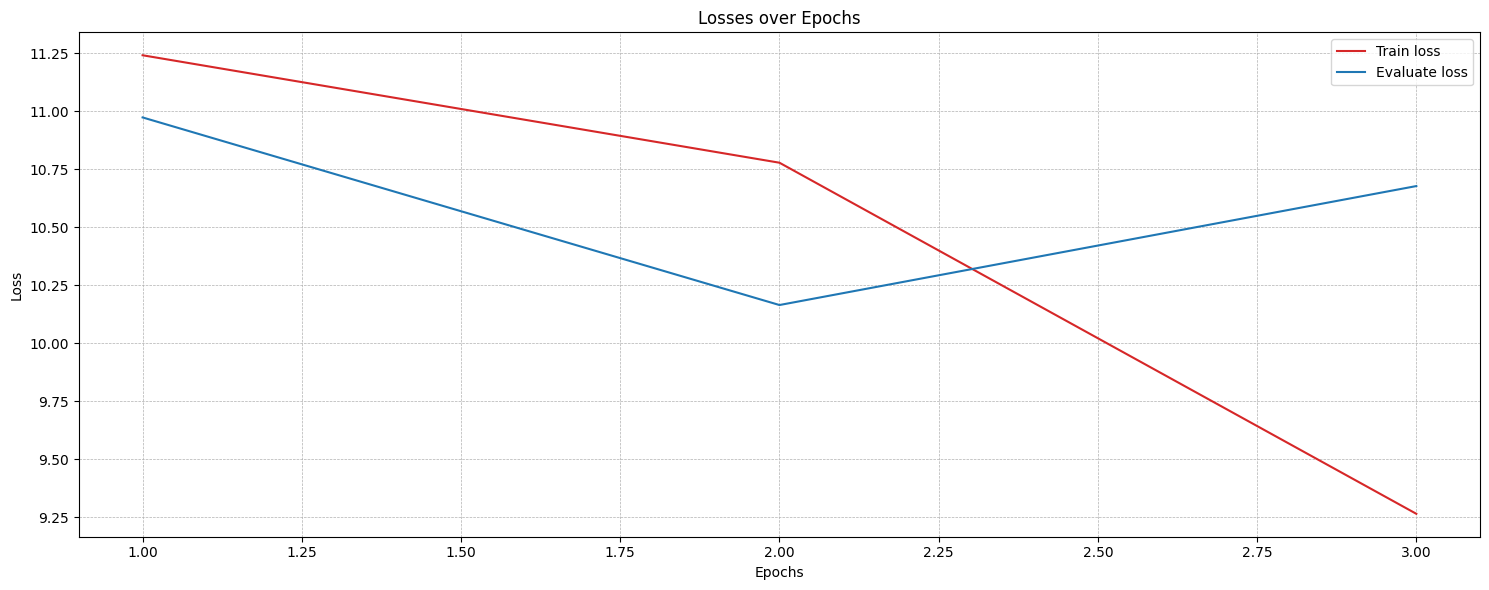

In [27]:
training_manager.plot_main_metrics()

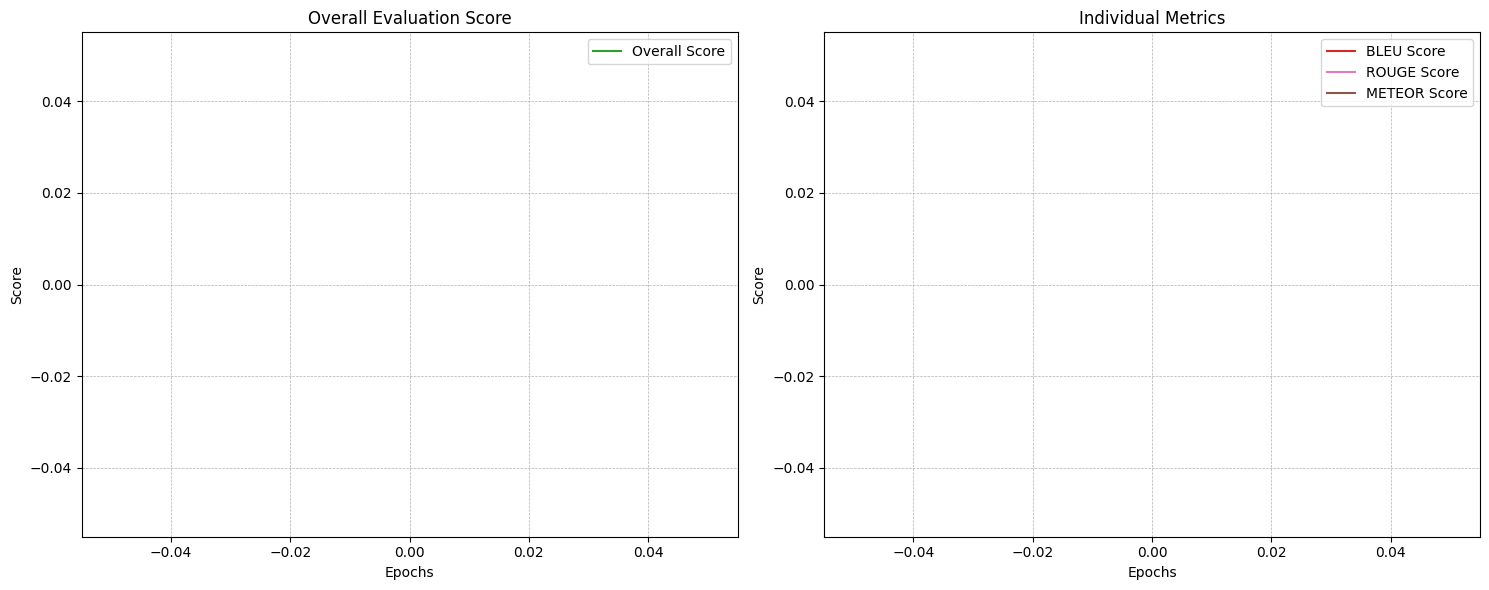

In [28]:
training_manager.plot_special_metrics()

In [29]:
# training_manager.save()

# Предикт

In [30]:
testing_train_data: pd.DataFrame = training_manager.train_dataloader.dataset.dataframe
testing_train_data = testing_train_data.reset_index()
testing_train_data.head()


,index,type_problem,source,target
0,1,10,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Специалисты ТСК ""Мосэнерго"" пров..."
1,5,10,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! 23.01.24 специалисты ТСК ""Мосэне..."
2,0,10,"Цифровизация услуг в любых сферах, а особенно ...",Здравствуйте! На трубопроводе центрального ото...
3,7,7,"Ув. Губернатор, почему Ваша команда не дает ко...","[id711165326|Галина], добрый день! В случае, е..."
4,2,10,"Цифровизация услуг в любых сферах, а особенно ...","Здравствуйте! Конкретизируйте, пожалуйста, Ваш..."


In [31]:
type_message = testing_train_data['type_problem'][0]
source = testing_train_data['source'][0]
target = testing_train_data['target'][0]

print(datafarme_encoders.decode('type_problem', type_message))

print('Source - ', source)
print('Target - ', target)

['Устранение проблемы']
Source -  Цифровизация услуг в любых сферах, а особенно в медицине – очень важное направление в развитии региона.

Но иногда на проблему надо взглянуть не в электронном виде, не на бумажке, а в живую, пообщавшись с неподставными людьми, а с настоящими жителями.

В нашем микрорайоне Левобережный города Химки и в 2023 и уже в 2024 году случаются постоянные аварии с теплоснабжением и с водоснабжением в связи с изношенностью труб и коммуникаций. Аварии «подлатают» для галочки и для фото и все, а проблемы не решена. Кругом гейзеры горячей воды, раскопанные ямы, часто холодные дома. Сейчас без отопления находятся несколько домов микрорайона.

И на таких гнилых коммуникациях хотят построить детский сад на территории Гимназии № 16 (сейчас МАОУ «Перспектива», 1 корпус), поставив весь микрорайон под угрозу лишения тепло и водоснабжения весь район.

Уважаемый губернатор, услышьте наше обращение! В нашем районе очереди нет, несмотря на отписки в комментариях об очереди в 60

In [32]:
generated_text = training_manager.generate_text(source, type_message, max_length=config.max_length, method='argmax')
print('argmax -', generated_text)

# generated_text = training_manager.generate_text(source, type_message, max_length=config.max_length, method='sampling', temperature=0.7,)
# print('sampling -', generated_text)

# generated_text = training_manager.generate_text(source, type_message, max_length=config.max_length, method='top_k', top_k=11)
# print('top_k -', generated_text)

# generated_text = training_manager.generate_text(source, type_message, max_length=config.max_length, method='top_p', top_p=0.9)
# print('top_p -', generated_text)

KeyboardInterrupt: 

In [ ]:
special_metrics = training_manager.trainer.evaluator.evaluate(
    hypotheses=[generated_text],
    references=[target]
)
print(special_metrics)

In [ ]:
special_metrics = training_manager.trainer.evaluator.evaluate(
    hypotheses=['Привет'],
    references=['Привки'],
)
print(special_metrics)